<a href="https://colab.research.google.com/github/jwells52/creating-ai-enabled-systems/blob/main/Research%20Project/notebooks/fsl_experiment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install EasyFSL

In [ ]:
%pip install easyfsl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.2/65.2 kB 1.5 MB/s eta 0:00:00


### Download Humpback Whale Identification dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rm -rf /root/.kaggle && mkdir /root/.kaggle && cp /content/drive/MyDrive/Research-Project/kaggle.json /root/.kaggle/kaggle.json && chmod 600 /root/.kaggle/kaggle.json && kaggle competitions download -c humpback-whale-identification
!unzip humpback-whale-identification.zip

### Clone GitHub repo

In [ ]:
# !git clone https://github.com/jwells52/creating-ai-enabled-systems.git
%cd creating-ai-enabled-systems/Research\ Project

/content/creating-ai-enabled-systems/Research Project


### Imports

In [ ]:
import os

import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

from easyfsl.methods import PrototypicalNetworks, FewShotClassifier, SimpleShot
from easyfsl.utils import evaluate
from easyfsl.samplers import TaskSampler

from torch import Tensor, nn
from torch.optim import SGD, Optimizer, Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, resnet34, resnet152

from typing import Callable

from modules.data_utils import HumpbackWhaleDataset, remove_new_whale_class, create_loaders
from modules.train import train_fsl, device, transform
from modules.plotting import fsl_plots


### Load dataset

In [ ]:
train_df = remove_new_whale_class(
  pd.read_csv('/content/creating-ai-enabled-systems/Research Project/data/training_10samples.csv')
)

valid_df = remove_new_whale_class(
    pd.read_csv('/content/creating-ai-enabled-systems/Research Project/data/validation_10samples.csv')
)


In [ ]:
print(f"Min # of samples for a class in training set = {train_df['class_count'].min()}")
print(f"Max # of samples for a class in training set = {train_df['class_count'].max()}")
print(f"# of classes in training set = {len(train_df['Id'].unique())}")


Min # of samples for a class in training set = 11
Max # of samples for a class in training set = 73
# of classes in training set = 181


In [ ]:
print(f"Min # of samples for a class in validation set = {valid_df['class_count'].min()}")
print(f"Max # of samples for a class in validation set = {valid_df['class_count'].max()}")
print(f"# of classes in validation set = {len(valid_df['Id'].unique())}")

Min # of samples for a class in validation set = 11
Max # of samples for a class in validation set = 48
# of classes in validation set = 46


### Set up PyTorch Dataset

In [ ]:
train_set = HumpbackWhaleDataset(
    image_dir='/content/train',
    labels=train_df,
    transform=transform
)

valid_set = HumpbackWhaleDataset(
    image_dir='/content/train',
    labels=valid_df,
    transform=transform
)

### Train network with 1, 3, and 5 shot learning

In [ ]:
# Train a fsl model with 1, 3, and 5 shot learning

# Define learning rate and epochs
n_epochs = 25
learning_rate = 1e-2

# Number of Training Task for each epoch
# A training task is a random sample of N shots (images) for M classes
n_task_per_epoch = 100

# Number of Validation tasks for evaluation during training
n_validation_tasks = 45

n_way     = 5
n_shots   = [1, 3, 5]
n_queries = [5, 5, 5]

train_loss_dict = dict()
valid_acc_dict  = dict()
for n_shot, n_query in zip(n_shots, n_queries):
  print(f'Training and Evaluating {n_shot}-shot learning')
  cnn = resnet34().to(device)
  few_shot_classifier = PrototypicalNetworks(cnn).to(device)
  loss_fn = torch.nn.CrossEntropyLoss()
  optimizer = SGD(few_shot_classifier.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

  train_loader, valid_loader = create_loaders(
      train_set, valid_set,
      n_way,
      n_shot,
      n_query,
      n_task_per_epoch,
      n_validation_tasks
  )

  train_losses, valid_accs = train_fsl(
      few_shot_classifier,
      train_loader,
      valid_loader,
      optimizer,
      loss_fn,
      n_epochs=n_epochs,
      use_tqdm=True,
      save_model=False
  )

  train_loss_dict[str(n_shot)] = train_losses
  valid_acc_dict[str(n_shot)]  = valid_accs

Training and Evaluating 1-shot learning
Epoch 1


Validation: 100%|██████████| 45/45 [00:13<00:00,  3.34it/s, accuracy=0.287]

Epoch 2



Validation: 100%|██████████| 45/45 [00:13<00:00,  3.22it/s, accuracy=0.335]

Epoch 3



Validation: 100%|██████████| 45/45 [00:13<00:00,  3.23it/s, accuracy=0.342]

Epoch 4



Validation: 100%|██████████| 45/45 [00:13<00:00,  3.27it/s, accuracy=0.388]

Epoch 5



Validation: 100%|██████████| 45/45 [00:13<00:00,  3.26it/s, accuracy=0.376]

Epoch 6



Validation: 100%|██████████| 45/45 [00:13<00:00,  3.34it/s, accuracy=0.504]

Epoch 7



Validation: 100%|██████████| 45/45 [00:13<00:00,  3.34it/s, accuracy=0.414]

Epoch 8



Validation: 100%|██████████| 45/45 [00:13<00:00,  3.26it/s, accuracy=0.509]

Epoch 9



Validation: 100%|██████████| 45/45 [00:13<00:00,  3.22it/s, accuracy=0.518]

Epoch 10



Validation: 100%|██████████| 45/45 [00:13<00:00,  3.31it/s, accuracy=0.515]

Epoch 11



Validation: 100%|██████████| 45/45 [00:13<00:00,  3.22it/s, accuracy=0.519]

Epoch 12



Validation: 100%|██████████| 45/45 [00:13<00:00,  3.32it/s, accuracy=0.555]

Epoch 13



Validation: 100%|██████████| 45/45 [00:13<00:00,  3.38it/s, accuracy=0.617]

Epoch 14



Validation: 100%|██████████| 45/45 [00:13<00:00,  3.28it/s, accuracy=0.562]

Epoch 15



Validation: 100%|██████████| 45/45 [00:13<00:00,  3.27it/s, accuracy=0.574]

Epoch 16



Validation: 100%|██████████| 45/45 [00:13<00:00,  3.28it/s, accuracy=0.603]

Epoch 17



Validation: 100%|██████████| 45/45 [00:13<00:00,  3.33it/s, accuracy=0.577]

Epoch 18



Validation: 100%|██████████| 45/45 [00:14<00:00,  3.20it/s, accuracy=0.628]

Epoch 19



Validation: 100%|██████████| 45/45 [00:13<00:00,  3.29it/s, accuracy=0.62]

Epoch 20



Validation: 100%|██████████| 45/45 [00:13<00:00,  3.45it/s, accuracy=0.676]

Epoch 21



Validation: 100%|██████████| 45/45 [00:13<00:00,  3.27it/s, accuracy=0.627]

Epoch 22



Validation: 100%|██████████| 45/45 [00:13<00:00,  3.27it/s, accuracy=0.626]

Epoch 23



Validation: 100%|██████████| 45/45 [00:13<00:00,  3.35it/s, accuracy=0.684]

Epoch 24



Validation: 100%|██████████| 45/45 [00:14<00:00,  3.21it/s, accuracy=0.65]

Epoch 25



Validation: 100%|██████████| 45/45 [00:14<00:00,  3.12it/s, accuracy=0.66]


Saving state of model checkpoint at last epoch to /content/drive/MyDrive/prototypical_network_resnet12_last_epoch
Training and Evaluating 3-shot learning
Epoch 1


Validation: 100%|██████████| 45/45 [00:18<00:00,  2.45it/s, accuracy=0.359]

Epoch 2



Validation: 100%|██████████| 45/45 [00:18<00:00,  2.41it/s, accuracy=0.434]

Epoch 3



Validation: 100%|██████████| 45/45 [00:18<00:00,  2.42it/s, accuracy=0.463]

Epoch 4



Validation: 100%|██████████| 45/45 [00:18<00:00,  2.39it/s, accuracy=0.482]

Epoch 5



Validation: 100%|██████████| 45/45 [00:18<00:00,  2.49it/s, accuracy=0.515]

Epoch 6



Validation: 100%|██████████| 45/45 [00:18<00:00,  2.48it/s, accuracy=0.588]

Epoch 7



Validation: 100%|██████████| 45/45 [00:18<00:00,  2.42it/s, accuracy=0.556]

Epoch 8



Validation: 100%|██████████| 45/45 [00:18<00:00,  2.41it/s, accuracy=0.547]

Epoch 9



Validation: 100%|██████████| 45/45 [00:18<00:00,  2.48it/s, accuracy=0.63]

Epoch 10



Validation: 100%|██████████| 45/45 [00:18<00:00,  2.46it/s, accuracy=0.672]

Epoch 11



Validation: 100%|██████████| 45/45 [00:18<00:00,  2.46it/s, accuracy=0.662]

Epoch 12



Validation: 100%|██████████| 45/45 [00:18<00:00,  2.46it/s, accuracy=0.678]

Epoch 13



Validation: 100%|██████████| 45/45 [00:18<00:00,  2.43it/s, accuracy=0.691]

Epoch 14



Validation: 100%|██████████| 45/45 [00:17<00:00,  2.52it/s, accuracy=0.715]

Epoch 15



Validation: 100%|██████████| 45/45 [00:18<00:00,  2.45it/s, accuracy=0.706]

Epoch 16



Validation: 100%|██████████| 45/45 [00:17<00:00,  2.52it/s, accuracy=0.735]

Epoch 17



Validation: 100%|██████████| 45/45 [00:18<00:00,  2.46it/s, accuracy=0.725]

Epoch 18



Validation: 100%|██████████| 45/45 [00:18<00:00,  2.45it/s, accuracy=0.768]

Epoch 19



Validation: 100%|██████████| 45/45 [00:18<00:00,  2.37it/s, accuracy=0.751]

Epoch 20



Validation: 100%|██████████| 45/45 [00:18<00:00,  2.44it/s, accuracy=0.754]

Epoch 21



Validation: 100%|██████████| 45/45 [00:18<00:00,  2.44it/s, accuracy=0.784]

Epoch 22



Validation: 100%|██████████| 45/45 [00:17<00:00,  2.51it/s, accuracy=0.764]

Epoch 23



Validation: 100%|██████████| 45/45 [00:18<00:00,  2.45it/s, accuracy=0.762]

Epoch 24



Validation: 100%|██████████| 45/45 [00:17<00:00,  2.52it/s, accuracy=0.784]

Epoch 25



Validation: 100%|██████████| 45/45 [00:18<00:00,  2.49it/s, accuracy=0.799]


Saving state of model checkpoint at last epoch to /content/drive/MyDrive/prototypical_network_resnet12_last_epoch
Training and Evaluating 5-shot learning
Epoch 1


Validation: 100%|██████████| 45/45 [00:22<00:00,  1.97it/s, accuracy=0.365]

Epoch 2



Validation: 100%|██████████| 45/45 [00:23<00:00,  1.92it/s, accuracy=0.43]

Epoch 3



Validation: 100%|██████████| 45/45 [00:22<00:00,  2.00it/s, accuracy=0.496]

Epoch 4



Validation: 100%|██████████| 45/45 [00:22<00:00,  2.00it/s, accuracy=0.522]

Epoch 5



Validation: 100%|██████████| 45/45 [00:22<00:00,  1.97it/s, accuracy=0.569]

Epoch 6



Validation: 100%|██████████| 45/45 [00:22<00:00,  1.99it/s, accuracy=0.6]

Epoch 7



Validation: 100%|██████████| 45/45 [00:23<00:00,  1.95it/s, accuracy=0.633]

Epoch 8



Validation: 100%|██████████| 45/45 [00:22<00:00,  1.96it/s, accuracy=0.648]

Epoch 9



Validation: 100%|██████████| 45/45 [00:23<00:00,  1.92it/s, accuracy=0.704]

Epoch 10



Validation: 100%|██████████| 45/45 [00:23<00:00,  1.93it/s, accuracy=0.667]

Epoch 11



Validation: 100%|██████████| 45/45 [00:23<00:00,  1.94it/s, accuracy=0.684]

Epoch 12



Validation: 100%|██████████| 45/45 [00:23<00:00,  1.94it/s, accuracy=0.746]

Epoch 13



Validation: 100%|██████████| 45/45 [00:23<00:00,  1.88it/s, accuracy=0.732]

Epoch 14



Validation: 100%|██████████| 45/45 [00:23<00:00,  1.92it/s, accuracy=0.749]

Epoch 15



Validation: 100%|██████████| 45/45 [00:23<00:00,  1.91it/s, accuracy=0.767]

Epoch 16



Validation: 100%|██████████| 45/45 [00:23<00:00,  1.95it/s, accuracy=0.779]

Epoch 17



Validation: 100%|██████████| 45/45 [00:22<00:00,  1.98it/s, accuracy=0.74]

Epoch 18



Validation: 100%|██████████| 45/45 [00:23<00:00,  1.92it/s, accuracy=0.78]

Epoch 19



Validation: 100%|██████████| 45/45 [00:23<00:00,  1.93it/s, accuracy=0.781]

Epoch 20



Validation: 100%|██████████| 45/45 [00:22<00:00,  1.98it/s, accuracy=0.806]

Epoch 21



Validation: 100%|██████████| 45/45 [00:22<00:00,  1.96it/s, accuracy=0.815]

Epoch 22



Validation: 100%|██████████| 45/45 [00:22<00:00,  1.99it/s, accuracy=0.778]

Epoch 23



Validation: 100%|██████████| 45/45 [00:23<00:00,  1.94it/s, accuracy=0.825]

Epoch 24



Validation: 100%|██████████| 45/45 [00:23<00:00,  1.95it/s, accuracy=0.828]

Epoch 25



Validation: 100%|██████████| 45/45 [00:23<00:00,  1.95it/s, accuracy=0.852]


Saving state of model checkpoint at last epoch to /content/drive/MyDrive/prototypical_network_resnet12_last_epoch


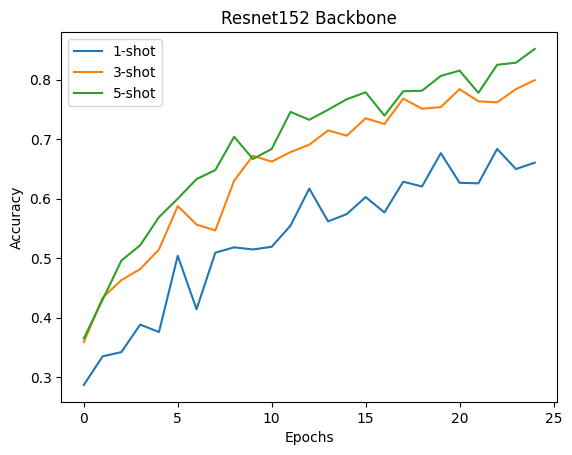

In [ ]:
fsl_plots(
    valid_acc_dict,
    title='Validation Accuracy on Varying Shots',
    ylabel='Accuracy',
    save_plot=True,
    save_path='/content/drive/MyDrive/Research-Project/shots_experiment_valid_acc.png'
  )

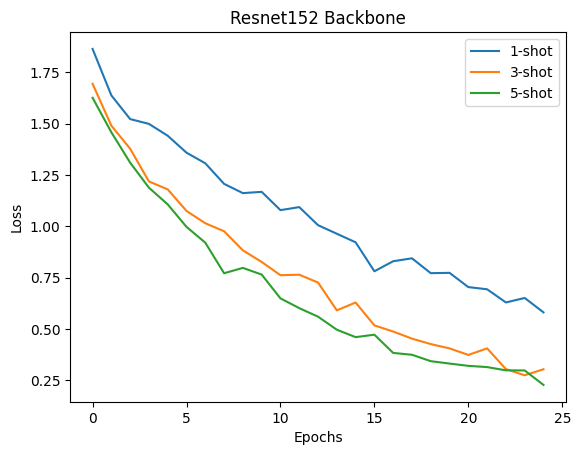

In [ ]:
fsl_plots(
    train_loss_dict,
    title='Training Loss on Varying Shots',
    ylabel='Loss',
    save_plot=True,
    save_path='/content/drive/MyDrive/Research-Project/shots_experiment_train_loss.png'

  )

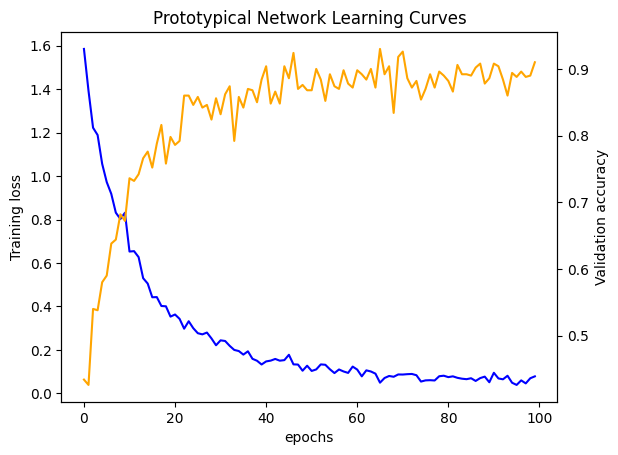

In [ ]:
# fig,ax = plt.subplots()

# plt.title('Prototypical Network Learning Curves')

# ax.plot(train_losses, color='blue')
# ax.set_xlabel("epochs")
# ax.set_ylabel('Training loss')

# ax2=ax.twinx()
# ax2.plot(valid_accs, color='orange')
# ax2.set_ylabel('Validation accuracy')

# plt.show()
# fig.savefig('/content/prototypical_network_resnet152_learning_curves_100epochs.png', format='png')

# 5-fold cross validation for the following shots

* 1-shot 10-way
* 5-shot 10-way
* 10-shot 10-way

In [ ]:
# Number of Training Task for each epoch
# A training task is a random sample of N shots (images) for M classes
n_task_per_epoch = 40

# Number of Validation tasks for evaluation during training
n_validation_tasks = 20

n_way   = 10
n_shot  = 1
n_query = 10

In [ ]:
n_epochs = 100
learning_rate = 1e-2

# loss_fn = torch.nn.CrossEntropyLoss()
# optimizer = SGD(few_shot_classifier.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

In [ ]:
# Load dataset
images_and_ids = pd.read_csv('/content/creating-ai-enabled-systems/Research Project/data/images_and_ids.csv')
images_and_ids = images_and_ids[images_and_ids['class_count'] > 10]
images_and_ids

,Image,Id,class_count
0,0000e88ab.jpg,w_f48451c,14
3,000a6daec.jpg,w_dd88965,16
6,001cae55b.jpg,w_581ba42,14
11,004e8ad5b.jpg,w_3de579a,54
12,004f87702.jpg,w_1d0830e,11
...,...,...,...
15688,ffca5cb22.jpg,w_51e7506,15
15689,ffcd5efdc.jpg,w_f765256,34
15691,ffe52d320.jpg,w_bc285a6,21
15693,ffef89eed.jpg,w_9c506f6,62


In [ ]:
whale_ids = np.unique(images_and_ids['Id'])
len(whale_ids)

227

In [ ]:
# Create folds
num_folds = 5
folds = []
for i in range(num_folds):
  start_fold = (len(whale_ids)//num_folds)*i
  end_fold   = (len(whale_ids)//num_folds)*(i+1)
  if i == num_folds-1:
    end_fold = len(whale_ids)

  fold = whale_ids[start_fold:end_fold]
  folds += [fold]

In [ ]:
transform = transforms.Compose(
        [
              transforms.Grayscale(num_output_channels=3),
              transforms.Resize((256, 512)),
              transforms.ToTensor(),
        ])

In [ ]:
train_losses_mean, train_losses_std = [], []
valid_accs_mean, valid_accs_std     = [], []
for fold in range(num_folds):
  torch.cuda.empty_cache()
  print(f'Fold {fold+1}')

  # Creating training/validation folds
  validation_fold = folds[i]
  training_folds = []
  for i in range(num_folds):
    if i != fold:
      training_folds.extend(folds[i])

  train_df = images_and_ids[images_and_ids['Id'].isin(training_folds)]
  valid_df = images_and_ids[images_and_ids['Id'].isin(validation_fold)]


  # Creating training/validation PyTorch datasets
  train_set = HumpbackWhaleDataset(
      image_dir='/content/train',
      labels=train_df,
      transform=transform

  )

  valid_set = HumpbackWhaleDataset(
      image_dir='/content/train',
      labels=valid_df,
      transform=transform
  )

  # Create TaskSamplers
  train_sampler = TaskSampler(
      train_set, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_task_per_epoch
  )

  valid_sampler = TaskSampler(
      valid_set, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_validation_tasks
  )

  # Create DataLoaders
  train_loader = DataLoader(
      train_set,
      batch_sampler=train_sampler,
      num_workers=12,
      pin_memory=True,
      collate_fn=train_sampler.episodic_collate_fn
  )

  valid_loader = DataLoader(
      valid_set,
      batch_sampler=valid_sampler,
      num_workers=12,
      pin_memory=True,
      collate_fn=valid_sampler.episodic_collate_fn
  )

  # Train and Validate
  cnn = resnet12().to(device)
  few_shot_classifier = PrototypicalNetworks(cnn).to(device)

  loss_fn = torch.nn.CrossEntropyLoss()
  optimizer = SGD(few_shot_classifier.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

  train_losses = []
  valid_accs = []
  for epoch in tqdm(range(n_epochs)):
      epoch_loss = training_epoch(few_shot_classifier, train_loader, optimizer, loss_fn)
      train_losses += [epoch_loss]

      valid_acc = evaluate(
          few_shot_classifier, valid_loader, device=device, use_tqdm=False
      )

      valid_accs += [valid_acc]

      optimizer.step()


  train_losses_mean += [np.mean(train_losses)]
  train_losses_std  += [np.std(train_losses)]

  valid_accs_mean += [np.mean(valid_accs)]
  valid_accs_std  += [np.std(valid_accs)]

  print(f'Average fold validation accuracy = {np.mean(valid_accs)} {chr(177)}{np.std(valid_accs)}')

Fold 1


  0%|          | 0/100 [00:18<?, ?it/s]


OutOfMemoryError: ignored